In [1]:
using Knet, CUDA,Images, Random, Statistics,Base,NPZ,Plots
const F = Float32
Atype = CUDA.functional() ? KnetArray{F} : Array{F};

include("model.jl")
include("utils.jl")
using .model
using .utils

In [2]:
function inference_forward(w,x,y_hat,data_mean,data_std,n)
    wdec, wenc = w[:decoder], w[:encoder]
    x_normalized = (x .- data_mean)./ data_std
    mu, logvar = encode(wenc, x_normalized)
    y_total = Atype(zeros(Float32,size(x)))
    for i in 1:n
        z = reparameterize(mu,logvar)
        y = decode(wdec,z)
        y  = (y.*data_std) .+ data_mean
        y_total = y_total .+ y
    end
    y_total = y_total./n
    return MSE(y_hat,y_total)
end

inference_forward (generic function with 1 method)

##### for 1000 samples I did not run model 5 times  since it takes more time (I will share the results over 5 runs soon)

# Fully Unsupervised

##  1 ) W2S Avg 16 Channel 0

In [3]:
channel = 0
avg = 16
dataset = string("w2s_avg",avg, "_channel_",channel)
train_data = npzread("../../Datasets/"*dataset*".npz");

In [4]:
xtrn=train_data["train"];
xval=train_data["val"];
xtst=train_data["test_GT"];
test_noisy = train_data["test"]
xtrn=permutedims(xtrn, [2, 3, 1]);
xval=permutedims(xval, [2, 3, 1]);
xtst=permutedims(xtst, [2, 3, 1]);
test_noisy=permutedims(test_noisy, [2, 3, 1]);
dtst = minibatch(test_noisy,xtst, 1; xsize = (512, 512, 1,:),ysize = (512, 512, 1,:), xtype = Atype,ytype=Atype);
data_mean,data_std = get_dataset_mean_std(xtrn,xval)

(147.0831928908825, 64.26004940377811)

In [5]:
w = Knet.load(dataset*"_best.jld2","w",);

In [6]:
psnr_list_10 = []
for i =1:5
    PSNR_total = 0
    for (i,x)  in enumerate(dtst)
        noisy,y = x
        mse = inference_forward(w,noisy,y,data_mean,data_std,10)
        min_y = minimum(y)
        max_y = maximum(y)
        PSNR_total += 10*Base.log10(((max_y-min_y)^2)/mse)
    end
    psnr = PSNR_total/length(dtst)
    push!(psnr_list_10,psnr)
end

psnr_list_100 = []
for i =1:5
    PSNR_total = 0
    for (i,x)  in enumerate(dtst)
        noisy,y = x
        mse = inference_forward(w,noisy,y,data_mean,data_std,100)
        min_y = minimum(y)
        max_y = maximum(y)
        PSNR_total += 10*Base.log10(((max_y-min_y)^2)/mse)
    end
    psnr = PSNR_total/length(dtst)
    push!(psnr_list_100,psnr)
end

psnr_list_1000 = []
for i =1:1
    PSNR_total = 0
    for (i,x)  in enumerate(dtst)
        noisy,y = x
        mse = inference_forward(w,noisy,y,data_mean,data_std,1000)
        min_y = minimum(y)
        max_y = maximum(y)
        PSNR_total += 10*Base.log10(((max_y-min_y)^2)/mse)
    end
    psnr = PSNR_total/length(dtst)
    push!(psnr_list_1000,psnr)
end

In [7]:
println.([psnr_list_10,psnr_list_100,psnr_list_1000]);

Any[39.461624f0, 39.44364f0, 39.445793f0, 39.433525f0, 39.439014f0]
Any[39.587753f0, 39.59025f0, 39.58502f0, 39.58593f0, 39.589516f0]
Any[39.601402f0]


In [8]:
println("mean PSNR and std over 5 runs (1000 samples results are over one run)\n")
println("Paper Reported Result")
println("1000 samples MMSE estimate : mean : 39.45 std :0.036")
println("-------------------\n")
println("10 samples MMSE estimate : mean : "*string(mean(psnr_list_10))*" std "*string(std(psnr_list_10)))
println("100 samples MMSE estimate : mean : "*string(mean(psnr_list_100))*" std "*string(std(psnr_list_100)))
println("1000 samples MMSE estimate  : mean : "*string(mean(psnr_list_1000))*" std "*string(std(psnr_list_1000)))

mean PSNR and std over 5 runs (1000 samples results are over one run)

Paper Reported Result
1000 samples MMSE estimate : mean : 39.45 std :0.036
-------------------

10 samples MMSE estimate : mean : 39.444717 std 0.0105586955
100 samples MMSE estimate : mean : 39.58769 std 0.0022426494
1000 samples MMSE estimate  : mean : 39.601402 std NaN


In [9]:
trn_recon_loss = Knet.load("recon_kld_loss/"*dataset*"_trn_recon_loss_fully_unsupervised.jld2","trn_recon_loss",)
trn_KLD_loss = Knet.load("recon_kld_loss/"*dataset*"_trn_KLD_loss_fully_unsupervised.jld2","trn_KLD_loss",)
val_recon_loss = Knet.load("recon_kld_loss/"*dataset*"_val_recon_loss_fully_unsupervised.jld2","val_recon_loss",)
val_KLD_loss = Knet.load("recon_kld_loss/"*dataset*"_val_KLD_loss_fully_unsupervised.jld2","val_KLD_loss",);

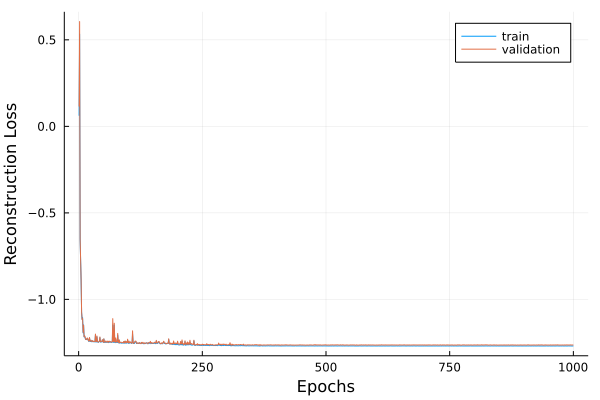

In [10]:
plot([trn_recon_loss, val_recon_loss],#ylim=(0.65,1.0),
     labels=["train" "validation"],xlabel="Epochs",ylabel="Reconstruction Loss")

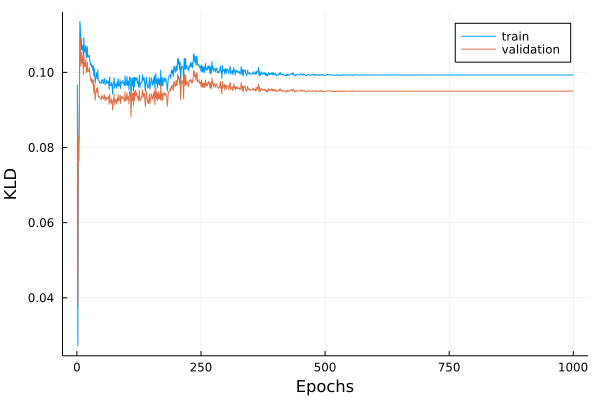

In [11]:
plot([trn_KLD_loss, val_KLD_loss],#ylim=(0.0,0.5),
     labels=["train" "validation"],xlabel="Epochs",ylabel="KLD")

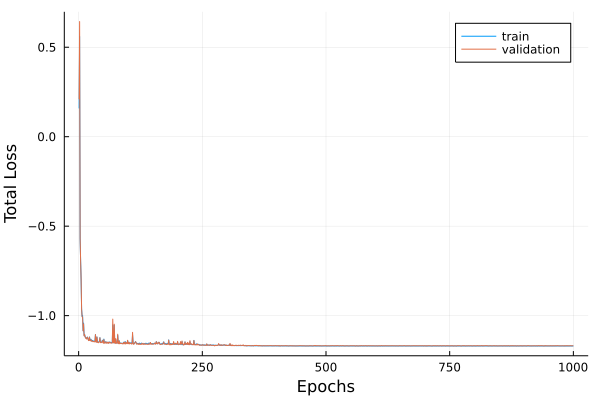

In [12]:
plot([trn_recon_loss.+trn_KLD_loss, val_recon_loss.+val_KLD_loss],#ylim=(0.65,1.0),
     labels=["train" "validation"],xlabel="Epochs",ylabel="Total Loss")

##  2 ) W2S Avg 16 Channel 1

In [13]:
channel = 1
avg = 16
dataset = string("w2s_avg",avg, "_channel_",channel)
train_data = npzread("../../Datasets/"*dataset*".npz");

In [14]:
xtrn=train_data["train"];
xval=train_data["val"];
xtst=train_data["test_GT"];
test_noisy = train_data["test"]
xtrn=permutedims(xtrn, [2, 3, 1]);
xval=permutedims(xval, [2, 3, 1]);
xtst=permutedims(xtst, [2, 3, 1]);
test_noisy=permutedims(test_noisy, [2, 3, 1]);
dtst = minibatch(test_noisy,xtst, 1; xsize = (512, 512, 1,:),ysize = (512, 512, 1,:), xtype = Atype,ytype=Atype);
data_mean,data_std = get_dataset_mean_std(xtrn,xval)

(183.38661063164471, 74.1990953566874)

In [15]:
w = Knet.load(dataset*"_best.jld2","w",);

In [16]:
psnr_list_10 = []
for i =1:5
    PSNR_total = 0
    for (i,x)  in enumerate(dtst)
        noisy,y = x
        mse = inference_forward(w,noisy,y,data_mean,data_std,10)
        min_y = minimum(y)
        max_y = maximum(y)
        PSNR_total += 10*Base.log10(((max_y-min_y)^2)/mse)
    end
    psnr = PSNR_total/length(dtst)
    push!(psnr_list_10,psnr)
end

psnr_list_100 = []
for i =1:5
    PSNR_total = 0
    for (i,x)  in enumerate(dtst)
        noisy,y = x
        mse = inference_forward(w,noisy,y,data_mean,data_std,100)
        min_y = minimum(y)
        max_y = maximum(y)
        PSNR_total += 10*Base.log10(((max_y-min_y)^2)/mse)
    end
    psnr = PSNR_total/length(dtst)
    push!(psnr_list_100,psnr)
end

psnr_list_1000 = []
for i =1:1
    PSNR_total = 0
    for (i,x)  in enumerate(dtst)
        noisy,y = x
        mse = inference_forward(w,noisy,y,data_mean,data_std,1000)
        min_y = minimum(y)
        max_y = maximum(y)
        PSNR_total += 10*Base.log10(((max_y-min_y)^2)/mse)
    end
    psnr = PSNR_total/length(dtst)
    push!(psnr_list_1000,psnr)
end

In [17]:
println.([psnr_list_10,psnr_list_100,psnr_list_1000]);

Any[38.255234f0, 38.26221f0, 38.25581f0, 38.257484f0, 38.26011f0]
Any[38.45113f0, 38.451653f0, 38.45261f0, 38.450977f0, 38.45005f0]
Any[38.46998f0]


In [18]:
println("mean PSNR and std over 5 runs (1000 samples results are over one run)\n")
println("Paper Reported Result")
println("1000 samples MMSE estimate : mean : 38.41 std :0.018")
println("-------------------\n")
println("10 samples MMSE estimate : mean : "*string(mean(psnr_list_10))*" std "*string(std(psnr_list_10)))
println("100 samples MMSE estimate : mean : "*string(mean(psnr_list_100))*" std "*string(std(psnr_list_100)))
println("1000 samples MMSE estimate  : mean : "*string(mean(psnr_list_1000))*" std "*string(std(psnr_list_1000)))

mean PSNR and std over 5 runs (1000 samples results are over one run)

Paper Reported Result
1000 samples MMSE estimate : mean : 38.41 std :0.018
-------------------

10 samples MMSE estimate : mean : 38.258167 std 0.0029474597
100 samples MMSE estimate : mean : 38.451283 std 0.00093992235
1000 samples MMSE estimate  : mean : 38.46998 std NaN


In [19]:
trn_recon_loss = Knet.load("recon_kld_loss/"*dataset*"_trn_recon_loss_fully_unsupervised.jld2","trn_recon_loss",)
trn_KLD_loss = Knet.load("recon_kld_loss/"*dataset*"_trn_KLD_loss_fully_unsupervised.jld2","trn_KLD_loss",)
val_recon_loss = Knet.load("recon_kld_loss/"*dataset*"_val_recon_loss_fully_unsupervised.jld2","val_recon_loss",)
val_KLD_loss = Knet.load("recon_kld_loss/"*dataset*"_val_KLD_loss_fully_unsupervised.jld2","val_KLD_loss",);

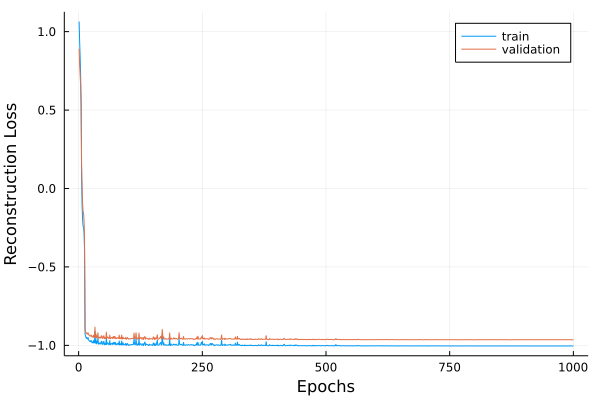

In [20]:
plot([trn_recon_loss, val_recon_loss],#ylim=(0.65,1.0),
     labels=["train" "validation"],xlabel="Epochs",ylabel="Reconstruction Loss")

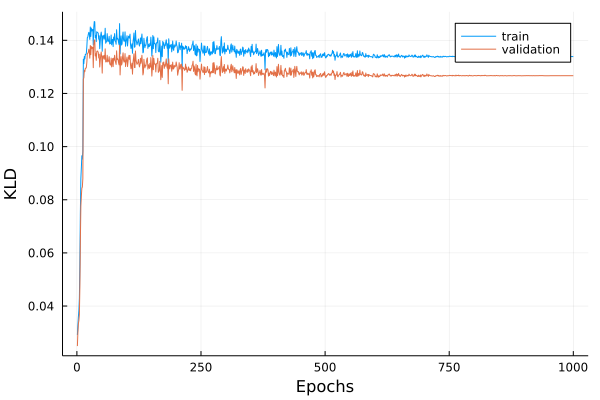

In [21]:
plot([trn_KLD_loss, val_KLD_loss],#ylim=(0.0,0.5),
     labels=["train" "validation"],xlabel="Epochs",ylabel="KLD")

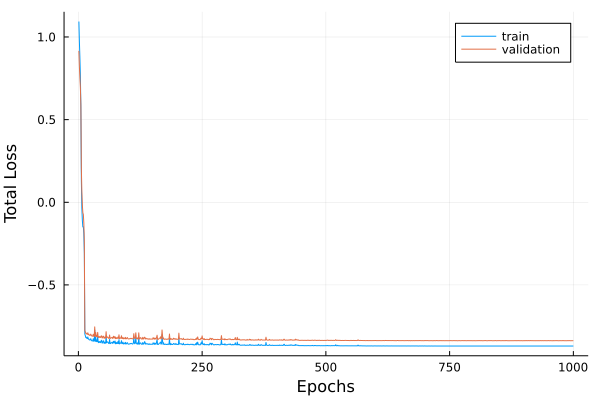

In [22]:
plot([trn_recon_loss.+trn_KLD_loss, val_recon_loss.+val_KLD_loss],#ylim=(0.65,1.0),
     labels=["train" "validation"],xlabel="Epochs",ylabel="Total Loss")

##  3 ) W2S Avg 16 Channel 2

In [23]:
channel = 2
avg = 16
dataset = string("w2s_avg",avg, "_channel_",channel)
train_data = npzread("../../Datasets/"*dataset*".npz");

In [24]:
xtrn=train_data["train"];
xval=train_data["val"];
xtst=train_data["test_GT"];
test_noisy = train_data["test"]
xtrn=permutedims(xtrn, [2, 3, 1]);
xval=permutedims(xval, [2, 3, 1]);
xtst=permutedims(xtst, [2, 3, 1]);
test_noisy=permutedims(test_noisy, [2, 3, 1]);
dtst = minibatch(test_noisy,xtst, 1; xsize = (512, 512, 1,:),ysize = (512, 512, 1,:), xtype = Atype,ytype=Atype);
data_mean,data_std = get_dataset_mean_std(xtrn,xval)

(161.34591233581304, 55.21280900752336)

In [25]:
w = Knet.load(dataset*"_best.jld2","w",);

In [26]:
psnr_list_10 = []
for i =1:5
    PSNR_total = 0
    for (i,x)  in enumerate(dtst)
        noisy,y = x
        mse = inference_forward(w,noisy,y,data_mean,data_std,10)
        min_y = minimum(y)
        max_y = maximum(y)
        PSNR_total += 10*Base.log10(((max_y-min_y)^2)/mse)
    end
    psnr = PSNR_total/length(dtst)
    push!(psnr_list_10,psnr)
end

psnr_list_100 = []
for i =1:5
    PSNR_total = 0
    for (i,x)  in enumerate(dtst)
        noisy,y = x
        mse = inference_forward(w,noisy,y,data_mean,data_std,100)
        min_y = minimum(y)
        max_y = maximum(y)
        PSNR_total += 10*Base.log10(((max_y-min_y)^2)/mse)
    end
    psnr = PSNR_total/length(dtst)
    push!(psnr_list_100,psnr)
end

psnr_list_1000 = []
for i =1:1
    PSNR_total = 0
    for (i,x)  in enumerate(dtst)
        noisy,y = x
        mse = inference_forward(w,noisy,y,data_mean,data_std,1000)
        min_y = minimum(y)
        max_y = maximum(y)
        PSNR_total += 10*Base.log10(((max_y-min_y)^2)/mse)
    end
    psnr = PSNR_total/length(dtst)
    push!(psnr_list_1000,psnr)
end

In [27]:
println.([psnr_list_10,psnr_list_100,psnr_list_1000]);

Any[40.15262f0, 40.140594f0, 40.13681f0, 40.139896f0, 40.139244f0]
Any[40.307705f0, 40.306328f0, 40.304832f0, 40.31102f0, 40.30942f0]
Any[40.32502f0]


In [28]:
println("mean PSNR and std over 5 runs (1000 samples results are over one run)\n")
println("Paper Reported Result")
println("1000 samples MMSE estimate : mean : 40.56 std :0.019")
println("-------------------\n")
println("10 samples MMSE estimate : mean : "*string(mean(psnr_list_10))*" std "*string(std(psnr_list_10)))
println("100 samples MMSE estimate : mean : "*string(mean(psnr_list_100))*" std "*string(std(psnr_list_100)))
println("1000 samples MMSE estimate  : mean : "*string(mean(psnr_list_1000))*" std "*string(std(psnr_list_1000)))

mean PSNR and std over 5 runs (1000 samples results are over one run)

Paper Reported Result
1000 samples MMSE estimate : mean : 40.56 std :0.019
-------------------

10 samples MMSE estimate : mean : 40.141834 std 0.0061955513
100 samples MMSE estimate : mean : 40.30786 std 0.0024474978
1000 samples MMSE estimate  : mean : 40.32502 std NaN


In [29]:
trn_recon_loss = Knet.load("recon_kld_loss/"*dataset*"_trn_recon_loss_fully_unsupervised.jld2","trn_recon_loss",)
trn_KLD_loss = Knet.load("recon_kld_loss/"*dataset*"_trn_KLD_loss_fully_unsupervised.jld2","trn_KLD_loss",)
val_recon_loss = Knet.load("recon_kld_loss/"*dataset*"_val_recon_loss_fully_unsupervised.jld2","val_recon_loss",)
val_KLD_loss = Knet.load("recon_kld_loss/"*dataset*"_val_KLD_loss_fully_unsupervised.jld2","val_KLD_loss",);

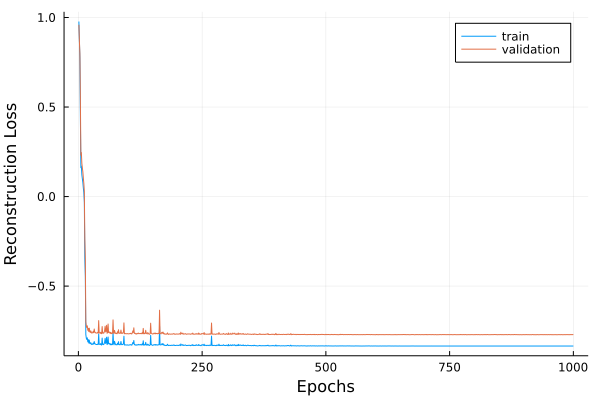

In [30]:
plot([trn_recon_loss, val_recon_loss],#ylim=(0.65,1.0),
     labels=["train" "validation"],xlabel="Epochs",ylabel="Reconstruction Loss")

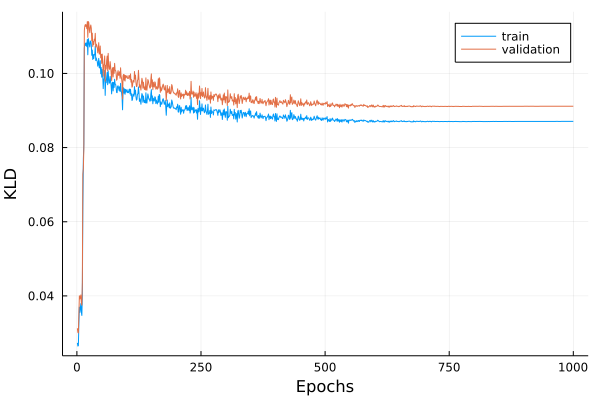

In [31]:
plot([trn_KLD_loss, val_KLD_loss],#ylim=(0.0,0.5),
     labels=["train" "validation"],xlabel="Epochs",ylabel="KLD")

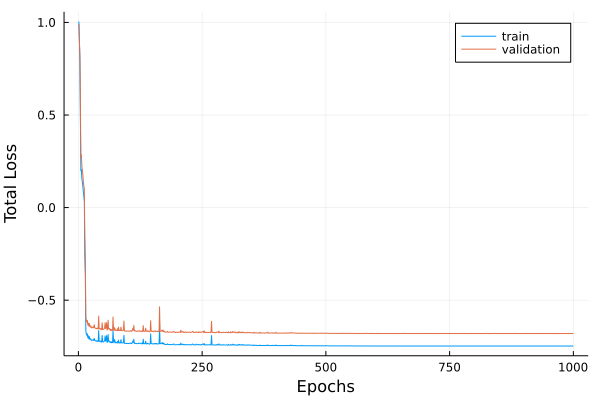

In [32]:
plot([trn_recon_loss.+trn_KLD_loss, val_recon_loss.+val_KLD_loss],#ylim=(0.65,1.0),
     labels=["train" "validation"],xlabel="Epochs",ylabel="Total Loss")